In [98]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score,silhouette_score,calinski_harabasz_score

<h1 style="color: lightblue;">Creating Data for Customers, I will be using same techniques for feature engineering that I have used for Lookalike</h1>


In [3]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [4]:
products.head(3)

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12


In [5]:
# merging products onto transactions
transactions = transactions.merge(products, on="ProductID", how="left")

In [6]:
# getting all we need
data = customers.merge(transactions,on = 'CustomerID',how='left')

In [7]:
data["TransactionDate"] = pd.to_datetime(data["TransactionDate"])

In [8]:
data.head(3)

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,ProductName,Category,Price_y
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2.0,114.60,57.30,SoundWave Cookbook,Books,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3.0,412.62,137.54,HomeSense Wall Art,Home Decor,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2.0,614.94,307.47,SoundWave Headphones,Electronics,307.47


<h1 style="color: lightblue;">Creating Feature Matrix</h1>


### We will use same way to generate features, as we did for Lookalike Task

In [9]:
customer_features = data.groupby("CustomerID").agg(
    # Money Wise 
    total_transactions=("TransactionID", "count"),
    total_spent=("TotalValue", "sum"),
    avg_spent=("TotalValue", "mean"),
    # Region Wise
    region=("Region", "first"),
    # Product and Category Wise (most imp)
    unique_products=("ProductID", lambda x: list(set(x))), 
    categories_purchased=("Category", lambda x: list(set(x))),
    total_quantity=("Quantity", "sum"), 
    # Date wise
    most_common_day=("TransactionDate", lambda x: x.dt.weekday.mode()[0] if not x.dt.weekday.mode().empty else None),
    most_common_month=("TransactionDate", lambda x: x.dt.month.mode()[0] if not x.dt.month.mode().empty else None), 
    most_common_hour=("TransactionDate", lambda x: x.dt.hour.mode()[0] if hasattr(x.dt, "hour") and not x.dt.hour.mode().empty else None)  # Most common hour
).reset_index()


In [10]:
customer_features.head(3)

,CustomerID,total_transactions,total_spent,avg_spent,region,unique_products,categories_purchased,total_quantity,most_common_day,most_common_month,most_common_hour
0,C0001,5,3354.52,670.904,South America,"[P029, P054, P096, P022, P083]","[Home Decor, Electronics, Books]",12.0,1.0,1.0,3.0
1,C0002,4,1862.74,465.685,Asia,"[P071, P004, P095, P019]","[Home Decor, Clothing]",10.0,1.0,2.0,1.0
2,C0003,4,2725.38,681.345,South America,"[P035, P002, P006, P025]","[Electronics, Home Decor, Clothing]",14.0,6.0,6.0,2.0


In [11]:
numerical_features = [
    "total_transactions", "total_spent", "avg_spent", "total_quantity", 
    "most_common_day", "most_common_month", "most_common_hour"
]

# Normalizing numerical features
scaler = StandardScaler()
customer_features[numerical_features] = scaler.fit_transform(customer_features[numerical_features])


In [12]:
# using tfidf for encoding category and product names

# converting lists to strings
customer_features['products_str'] = customer_features['unique_products'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else '')
customer_features['categories_str'] = customer_features['categories_purchased'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else '')

# seperate tfidf instance for category and product
vectorizer_products = TfidfVectorizer()
tfidf_matrix_products = vectorizer_products.fit_transform(customer_features['products_str'])
vectorizer_categories = TfidfVectorizer()
tfidf_matrix_categories = vectorizer_categories.fit_transform(customer_features['categories_str'])

# matrices to dataframes
tfidf_df_products = pd.DataFrame(tfidf_matrix_products.toarray(), columns=vectorizer_products.get_feature_names_out())
tfidf_df_categories = pd.DataFrame(tfidf_matrix_categories.toarray(), columns=vectorizer_categories.get_feature_names_out())

# final feature vector
customer_features = pd.concat([customer_features, tfidf_df_products, tfidf_df_categories], axis=1)


In [13]:
# encoding region
label_encoder = LabelEncoder()
customer_features['region_encoded'] = label_encoder.fit_transform(customer_features['region'])

In [14]:
# dropping columns which are now not necessary
final_features = customer_features.drop(['region','unique_products','categories_purchased','products_str','categories_str'],axis=1)

In [15]:
final_features.head(5)

,CustomerID,total_transactions,total_spent,avg_spent,total_quantity,most_common_day,most_common_month,most_common_hour,nan,p001,...,p098,p099,p100,books,clothing,decor,electronics,home,nan,region_encoded
0,C0001,0.000000,-0.051884,-0.070263,-0.110735,-0.649939,-1.052254,-0.653061,0.0,0.0,...,0.0,0.0,0.0,0.470528,0.000000,0.511218,0.505882,0.511218,0.0,3
1,C0002,-0.451294,-0.862714,-0.934933,-0.434049,-0.649939,-0.724557,-0.968496,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.583437,0.574283,0.000000,0.574283,0.0,0
2,C0003,-0.451294,-0.393842,-0.026271,0.212579,1.978879,0.586232,-0.810779,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.507250,0.499291,0.494080,0.499291,0.0,3
3,C0004,1.353881,1.035375,-0.076769,1.667493,-1.175703,2.552417,0.450961,0.0,0.0,...,0.0,0.0,0.0,0.470528,0.000000,0.511218,0.505882,0.511218,0.0,3
4,C0005,-0.902587,-0.769499,-0.040028,-0.919021,-1.175703,-0.396860,-1.126214,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.579359,0.573312,0.579359,0.0,0


In [19]:
features = final_features.drop(['CustomerID'],axis = 1)

In [20]:
features.fillna(0,inplace=True)

<h1 style="color: lightblue;">Final Feature Column</h1>

In [83]:
features.head(2)

,total_transactions,total_spent,avg_spent,total_quantity,most_common_day,most_common_month,most_common_hour,nan,p001,p002,...,p098,p099,p100,books,clothing,decor,electronics,home,nan,region_encoded
0,0.000000,-0.051884,-0.070263,-0.110735,-0.649939,-1.052254,-0.653061,0.0,0.0,0.0,...,0.0,0.0,0.0,0.470528,0.000000,0.511218,0.505882,0.511218,0.0,3
1,-0.451294,-0.862714,-0.934933,-0.434049,-0.649939,-0.724557,-0.968496,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.583437,0.574283,0.000000,0.574283,0.0,0


# Explanation:

1. First all required fields taken into customers dataframe from other products and transactions which contain information we can use to find similar users, this is done using simple group by function
2. Next we want to create fetaures that we can use
3. First feaatures I created were dependent on Actual Transaction Money and total and average, this gives us money wise features
4. They are numerical featires so no need to encode
5. Next I used Regions to get region wise features. They are encoded using label encoder in previous cell.
6. Next I used Category of products and actal products. Firat they were converted to list then string and then in vectors using TfIDF vectorizer
7. Next I used transaction date to extract month,day,weekday and hour.
8. At last I normalized all numerical columns except tfidf features as they are important as it is
9. Last we get a feature matrix

<h1 style="color: lightblue;">Clustering</h1>

<h2 style="color: red;">1. Using KMeans without Dimentionality Reduction </h2>

### Getting perfect clusters with Elbow Method

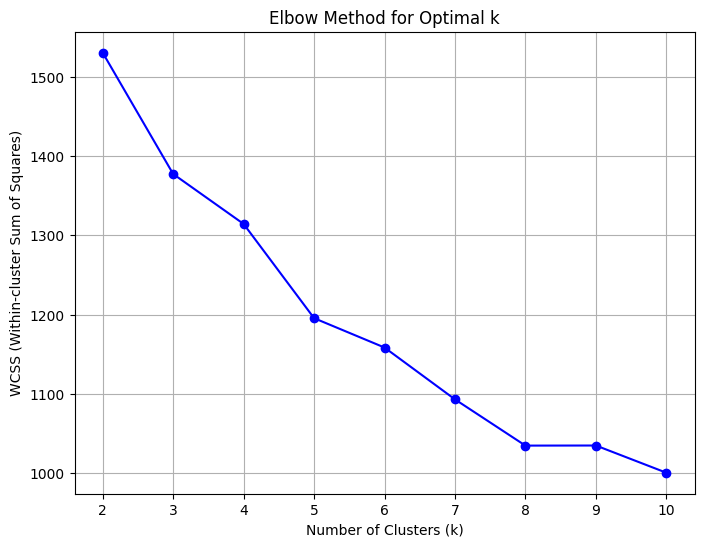

In [111]:
# Using Standard elbow method for getting appropriate clustering number
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS

plt.figure(figsize=(8,6))
plt.plot(range(2, 11), wcss, marker='o', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-cluster Sum of Squares)')
plt.grid(True)
plt.show()

In [112]:
wcss_diff = np.diff(wcss)
wcss_diff2 = np.diff(wcss_diff)
elbow_index = np.argmin(wcss_diff2)
optimal_k = elbow_index + 2
print(f"Optimal Number of clusters (k) is: {optimal_k}")


Optimal Number of clusters (k) is: 3


<h3 style="color: green;">Optimal Cluster No : 3</h3>

In [113]:
kmeans = KMeans(n_clusters=3, random_state=42)
customers['Cluster'] = kmeans.fit_predict(features)

In [114]:
# Calculate DB Index
db_index = davies_bouldin_score(features, customers['Cluster'])
print(f"DB Index: {db_index}")

# Calculate Silhouette Score
sil_score = silhouette_score(features, customers['Cluster'])
print(f"Silhouette Score: {sil_score}")

# Calculate Calinski-Harabasz Score
calinski_score = calinski_harabasz_score(features, customers['Cluster'])
print(f"Calinski-Harabasz Score: {calinski_score}")

DB Index: 2.0877147499496918
Silhouette Score: 0.12444256684400504
Calinski-Harabasz Score: 37.854613630869636


<h3 style="color: green;">DB Index = 2.0877</h3>
<h3 style="color: green;">Silhouette Score = 0.1244</h3>
<h3 style="color: green;">Calinski-Harabasz Score = 37.85</h3>

### Visualizing 3 clusters using PCA

In [88]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(features)

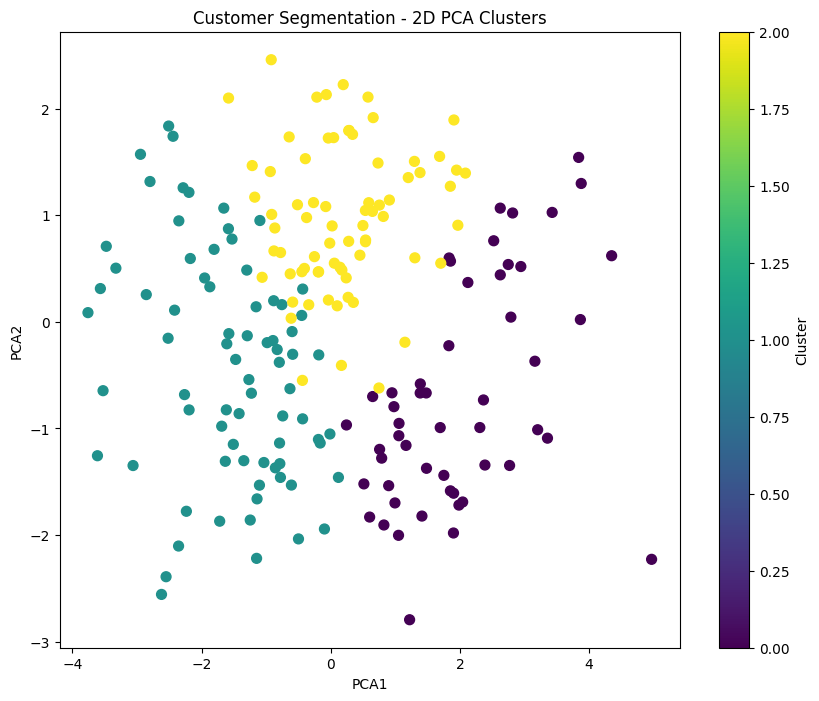

In [89]:
customers[['PCA1', 'PCA2']] = pca_components

plt.figure(figsize=(10, 8))
plt.scatter(customers['PCA1'], customers['PCA2'], c=customers['Cluster'], cmap='viridis', s=50)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Customer Segmentation - 2D PCA Clusters')
plt.colorbar(label='Cluster')
plt.show()


#

<h2 style="color: red;">2. Using Kmeans with Dimentionality Reduction</h2>

In [104]:
# 3 components
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(features)

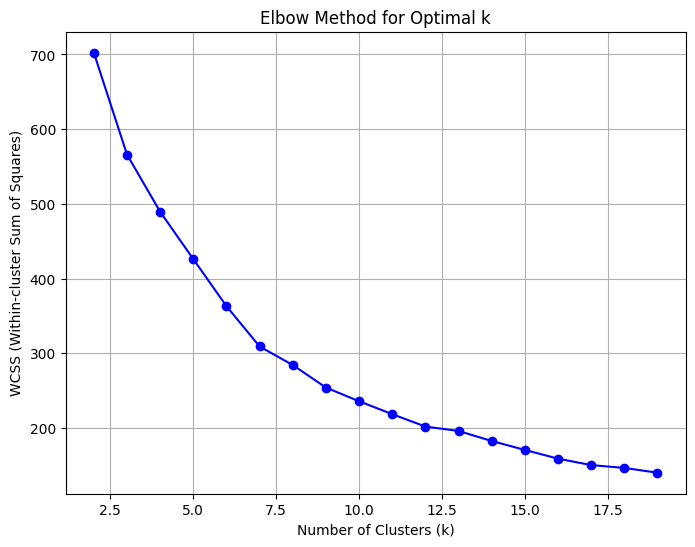

In [105]:
wcss = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_features)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS

# Plot the Elbow Method graph
plt.figure(figsize=(8,6))
plt.plot(range(2, 20), wcss, marker='o', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-cluster Sum of Squares)')
plt.grid(True)
plt.show()

In [106]:
wcss_diff = np.diff(wcss)
wcss_diff2 = np.diff(wcss_diff)
elbow_index = np.argmin(wcss_diff2)
optimal_k = elbow_index + 2
print(f"Optimal Number of clusters (k) is: {optimal_k}")


Optimal Number of clusters (k) is: 12


<h3 style="color: green;">Optimal Cluster No : 12</h3>

In [115]:
kmeans = KMeans(n_clusters=12, random_state=42)
customers['Cluster'] = kmeans.fit_predict(reduced_features)

In [116]:
# Calculate DB Index
db_index = davies_bouldin_score(reduced_features, customers['Cluster'])
print(f"DB Index: {db_index}")

# Calculate Silhouette Score
sil_score = silhouette_score(features, customers['Cluster'])
print(f"Silhouette Score: {sil_score}")

# Calculate Calinski-Harabasz Score
calinski_score = calinski_harabasz_score(features, customers['Cluster'])
print(f"Calinski-Harabasz Score: {calinski_score}")

DB Index: 1.0708283643063388
Silhouette Score: 0.06717557588776848
Calinski-Harabasz Score: 15.890048025294723


<h3 style="color: green;">DB Index = 1.07</h3>
<h3 style="color: green;">Silhouette Score = 0.06</h3>
<h3 style="color: green;">Calinski-Harabasz Score = 15.89</h3>

### Visualizing 12 clusters

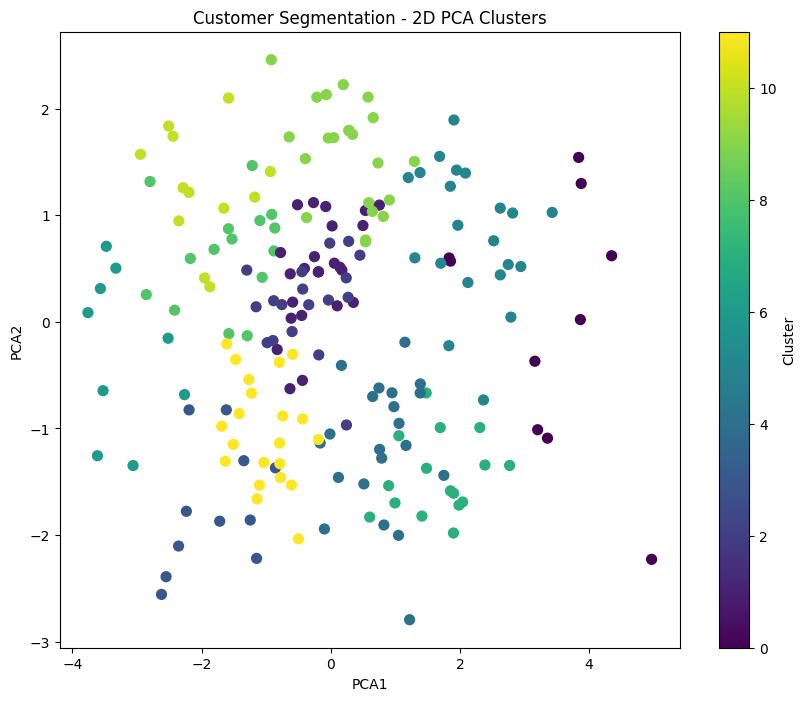

In [97]:
customers[['PCA1', 'PCA2','_']] = reduced_features
plt.figure(figsize=(10, 8))
plt.scatter(customers['PCA1'], customers['PCA2'], c=customers['Cluster'], cmap='viridis', s=50)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Customer Segmentation - 2D PCA Clusters')
plt.colorbar(label='Cluster')
plt.show()


#

<h1 style="color: lightblue;">Final Thoughts</h1>


1. I think I have used too complex feature engineering for this clustering specific task.
2. I think features could have been created in more simple manner that may or may not have been resulted in more good results
3. Lesser features may result in better result, but I liked this because I wanted to go all in for how each feature can be used to store more knowledge about each user.
4. Using diffrent feature engineering , with try and error the score can be furthur imporved
5. DBScan, another clustering algorithm can be used and tested against this Kmeans algorithm 